# Comparison of ARIMA and LSTM for time series forecasting
## Electricity consumption dataset

We compare the performance of traditional ARIMA models and Recurrent Neural Networks (LSTMs) for time series forecasting.



There are numerous ways of formulating a time series forecasting problem depending on the business scenario.

We simulate two scenarios. In both scenarios a time series model is trained and deployed, and we monitor its test performance over time. 
The model is not retrained during this testing phase.

1. **One-step moving origin forecasting**: 
 We produce a one-step forecast at each time step t and we observe a new data point that is added to the training dataset to compute the next step forecast. This is called 'moving origin' since we always observe a new data point at time t and thus the model is using only true historical data for every one-step forecast.

2. **Fixed origin forecasting:** Fixed origin means that the forecast we make at time step t will be added to the training dataset to compute the forecast at step t+1. This problem formulation is arguably more challenging than (1) as the model is using its own forecasts to generate further forecasts. 

Both monitoring strategies produce a sequence of one-step forecasts, which can be compared against the true test observations. 

As a measure of performance of the models, we use **MAPE** (mean absolute percentage error). 



In [ ]:
# install packages
!pip install statsmodels==0.12.1
!pip install sktime
!pip install pmdarima-
!pip install tensorflow

# RESTART RUNTIME AFTER INSTALLATION 
exit()

     |████████████████████████████████| 9.5 MB 3.3 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 6.5 MB 3.2 MB/s 
     |████████████████████████████████| 3.3 MB 18.0 MB/s 
     |████████████████████████████████| 34.5 MB 9.7 kB/s 
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.34.0
    Uninstalling llvmlite-0.34.0:
      Successfully uninstalled llvmlite-0.34.0
  Attempting uninstall: numba
    Found existing installation: numba 0.51.2
    Uninstalling numba-0.51.2:
      Successfully uninstalled numba-0.51.2
ERROR: Invalid requirement: 'pmdarima-'
     |████████████████████████████████| 462 kB 3.2 MB/s 


In [13]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/Projects/Time-Series-ARIMA-vs-LSTM/Time-Series-ARIMA-vs-LSTM

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks/Projects/Time-Series-ARIMA-vs-LSTM/Time-Series-ARIMA-vs-LSTM


# Data preprocessing

In [ ]:
# basic imports
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

dataset = pd.read_csv('electricity-clean.csv', index_col = 0, sep = ';')
dataset.index = pd.to_datetime(dataset.index)

In [ ]:
# creating an exogeneous variable 'holidays' (for supervised learning)
import holidays 

hol = pd.to_datetime(holidays.CountryHoliday('Finland')['2017-01-01':'2019-12-31'])

exo = dataset.copy()
exo["holidays"] = 0
exo.loc[hol] = 1
exo.drop(["kWh"], axis=1, inplace=True)

dataset["holidays"] = exo["holidays"]

In [ ]:
# creating exogeneous variables by cyclical encoding (for supervised learning)
import datetime

date = dataset.index
timest = date.map(datetime.datetime.timestamp)

week = 7*24*60*60
dataset['week_sin'] = np.sin(timest * (2 * np.pi / week))
dataset['week_cos'] = np.cos(timest * (2 * np.pi / week))


In [ ]:
# define response variable name

response_var = "kWh" 

In [ ]:
# scale data (for supervised learning)
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler_kwh = MinMaxScaler(feature_range=(0, 1)).fit(dataset[[response_var]])
data_normalized = pd.DataFrame(scaler.fit_transform(dataset),
                               columns = dataset.columns.values,
                               index = dataset.index)


In [ ]:
def rescale(y_pred, index):
    '''
    Rescale predictions back to original scale.
    '''
    y_pred_rescaled = scaler_kwh.inverse_transform(y_pred.reshape(-1,1)).flatten()
    y_pred_rescaled = pd.Series(y_pred_rescaled, index = index)

    return y_pred_rescaled

## Exploratory plots

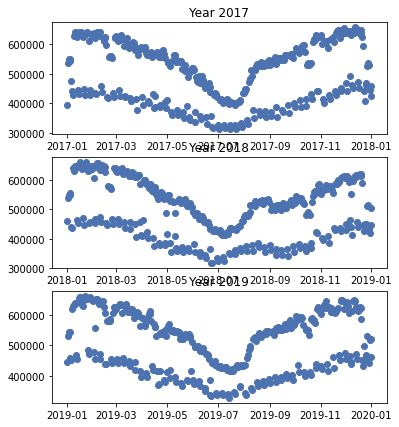

In [ ]:
# plot electricity usage for each year separately
plt.style.use('seaborn-deep')

fig, ax = plt.subplots(3, figsize = (6, 7))

y2017 = dataset.loc['2017-01-01':'2018-01-01']['kWh'] 
y2018 = dataset.loc['2018-01-01':'2019-01-01']['kWh'] 
y2019 = dataset.loc['2019-01-01':'2020-01-01']['kWh']

ax[0].set_title('Year 2017')
ax[0].plot(y2017, 'o')

ax[1].set_title('Year 2018')
ax[1].plot(y2018, 'o')

ax[2].set_title('Year 2019')
ax[2].plot(y2019, 'o')

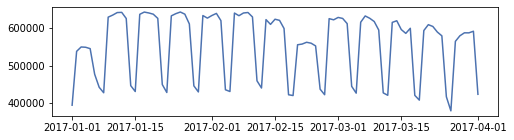

In [ ]:
# jan-feb-mar plot

df_janfebmar2017 = dataset.loc['2017-01-01':'2017-04-01']['kWh']
df_janfebmar2017

plt.figure(figsize = (8, 2))
plt.plot(df_janfebmar2017)

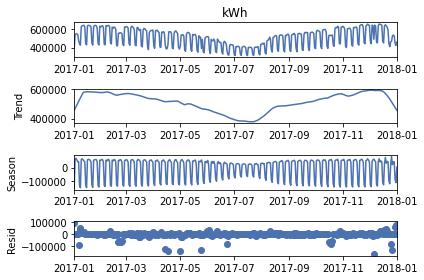

In [ ]:
# seasonal decomposition

from statsmodels.tsa.seasonal import seasonal_decompose, STL

stl = STL(y2017, seasonal = 7, robust = True)
stl.fit().plot()
plt.show()

# ARIMA

## ARIMA exploratory analysis 


In [ ]:

# tests for stationarity
from statsmodels.tsa.stattools import adfuller, kpss

def stationarity_tests(df):
    # ADF (H0: unit root is present)
    res_adf = adfuller(df)
    print(f"p-value ADF: {res_adf[1]}")
    
    # KPSS (H0: stationary)
    statistic, p_value, n_lags, critical_values = kpss(df, nlags="auto")
    print(f"p-value KPSS: {p_value}")

In [ ]:
stationarity_tests(dataset[response_var])

p-value ADF: 0.06351485361587028
p-value KPSS: 0.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


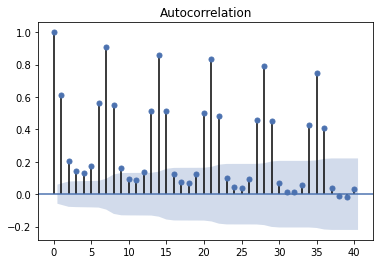

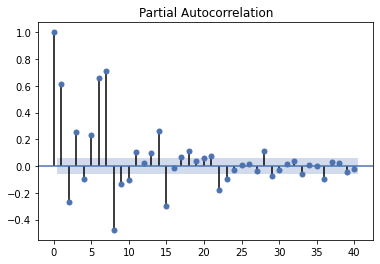

<Figure size 144x144 with 0 Axes>

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(dataset[response_var], lags=40)
plot_pacf(dataset[response_var], lags=40)
plt.figure(figsize = (2,2))
plt.show()

p-value ADF: 1.7760791220330254e-11
p-value KPSS: 0.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1886: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


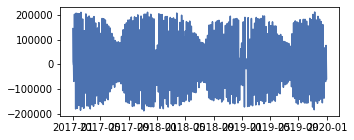

In [ ]:
from statsmodels.tsa.statespace.tools import diff

diff1 = diff(dataset[response_var])
plt.figure(figsize = (5,2))
plt.plot(diff1)

stationarity_tests(diff1)

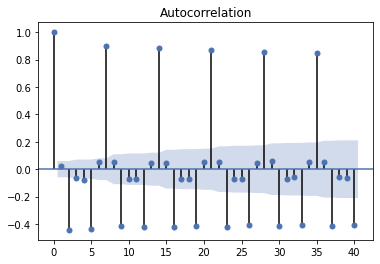

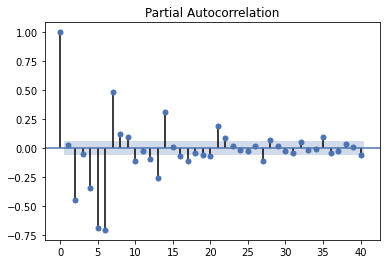

In [ ]:
plot_acf(diff1, lags=40)
plot_pacf(diff1, lags=40)
plt.show()

## SARIMAX

In [ ]:
# train test split

train_end = '2019-11-01' 
test_end = '2020-01-01'

train, test = dataset[:train_end][response_var], dataset[train_end:][response_var]
exo_train, exo_test = exo[:train_end], exo[train_end:]

In [ ]:
import itertools

# define parameters for grid search
p, d, q = range(0,3), [1], range(0,3)
P, D, Q, s = range(0,3), [1], range(0,3), [7]

pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
params_grid = list(itertools.product(pdq,seasonal_pdq))


In [ ]:
import statsmodels.api as sm

def optim_pars_SARIMA(params_grid, exo_train = pd.DataFrame({})):
    '''
    For each parameter combination in 'params_grid', fit a SARIMA model. Compute and return AICs.
    Optionally can add exogeneous variables. 
    '''
    AIC = []
    for param in params_grid:
        order = param[0]
        seasonal_order = param[1]

        #train.index = pd.DatetimeIndex(train.index.values,
        #                               freq=train.index.inferred_freq)

        if exo_train.empty:
            sar = sm.tsa.statespace.SARIMAX(endog = train,
                                            order = order,
                                            seasonal_order = seasonal_order)
        else:
            sar = sm.tsa.statespace.SARIMAX(endog = train,
                                            exog = exo_train,
                                            order = order,
                                            seasonal_order = seasonal_order)
        res = sar.fit(disp=False)
        AIC.append((param, res.aic, res))

    return AIC

# with exogeneous variables
AIC = optim_pars_SARIMA(params_grid)

AIC.sort(key = lambda x: x[1])

# optimal model according to AIC
print(f"\n Optimal model: parameters = {AIC[0]}")

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packa


 Optimal model: parameters = (((2, 1, 2), (1, 1, 2, 7)), 24054.87818221991, <statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper object at 0x7fd20e5168d0>)


## Residual analysis for model validation



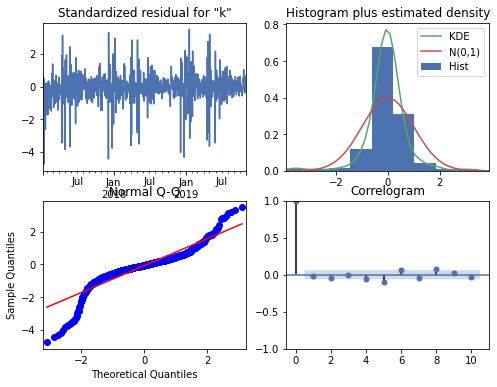

In [ ]:
res_opt = AIC[0][2]
res_opt.plot_diagnostics(figsize = (8,6))
plt.show()

## SARIMAX forecasts

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

# one-step fixed origin forecasts
pred_test = res_opt.get_prediction(start = train_end, end = test_end)

err = 'MAPE one-step fixed origin: %.3f'% MAPE(test, pred_test.predicted_mean) + \
'\nRMSE one-step fixed origin: %.3f'% np.sqrt(MSE(test, pred_test.predicted_mean))

print(err)

results_onestep_fixed = []
# results: [model_name, predictions, MAPE_error, MSE_error]
results_onestep_fixed.append(['SARIMAX', pred_test.predicted_mean, MAPE(test, pred_test.predicted_mean), np.sqrt(MSE(test, pred_test.predicted_mean))])


MAPE one-step fixed origin: 0.114
RMSE one-step fixed origin: 80921.313


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


In [ ]:
# one-step moving origin forecasts
# We obtain these forecasts using a workaround: we define a model on full dataset but then make predictions 
# using the parameters from 'res_opt' model (sending 'res_opt.params' to the new model)

order = AIC[0][0][0]
seasonal_order = AIC[0][0][1]

mod = sm.tsa.statespace.SARIMAX(dataset['kWh'], 
                                order = order, 
                                seasonal_order = seasonal_order)
res_roll = mod.filter(res_opt.params)
preds_arima_roll = res_roll.predict()
preds_arima_roll = preds_arima_roll[test.index]
preds_arima_roll

results_onestep_moving = []
results_onestep_moving.append(['SARIMAX', 
                               preds_arima_roll, 
                               MAPE(test, preds_arima_roll), 
                               np.sqrt(MSE(test, preds_arima_roll))])

err_moving = 'MAPE one-step moving origin: %.2f'% MAPE(test, preds_arima_roll) + \
'\nRMSE one-step moving origin: %.2f'% np.sqrt(MSE(test, preds_arima_roll))

print(err_moving)


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


MAPE one-step moving origin: 0.05
RMSE one-step moving origin: 35737.02


Text(0.5, 1.0, 'One-step fixed origin forecasts')

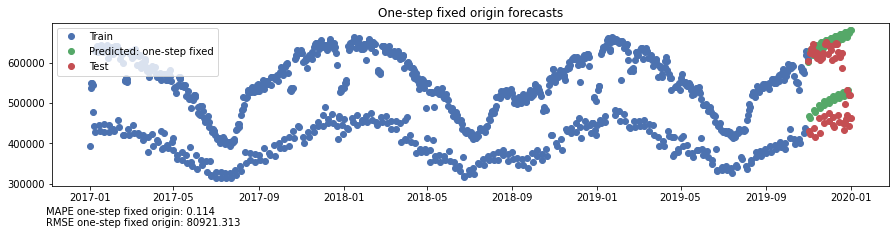

In [ ]:
# predictions
plt.figure(figsize = (15,3))
plt.plot(train, 'o', label = "Train")
plt.plot(pred_test.predicted_mean, 'o', label = "Predicted: one-step fixed")
plt.plot(test, 'o', label = "Test")
plt.figtext(0.12, -0.06, err)
plt.legend(loc ='upper left')
plt.title('One-step fixed origin forecasts')


Text(0.5, 1.0, 'One-step fixed origin forecasts')

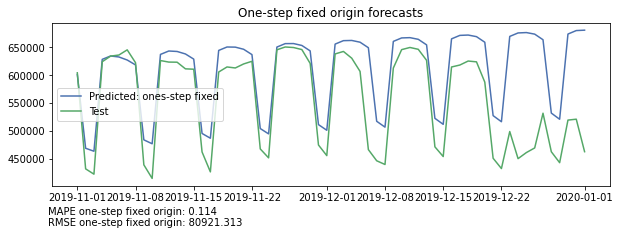

In [ ]:
# predictions on the test set
plt.figure(figsize = (10,3))
plt.plot(pred_test.predicted_mean,  label = "Predicted: ones-step fixed")
plt.plot(test,  label = "Test")
plt.figtext(0.12, -0.06, err)
plt.legend()
plt.title('One-step fixed origin forecasts')


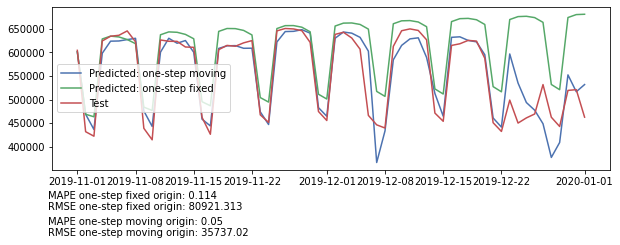

In [ ]:
# onestep moving origin

plt.figure(figsize = (10,3))
plt.plot(preds_arima_roll,  label = "Predicted: one-step moving")
plt.plot(pred_test.predicted_mean,  label = "Predicted: one-step fixed")
plt.plot(test,  label = "Test")
plt.figtext(0.12, -0.06, err)
plt.figtext(0.12, -0.18, err_moving)
plt.legend()


# LSTM

In [ ]:
from pandas import read_csv
from pandas import DataFrame
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
 
# convert series to supervised learning
def series_to_supervised(data, num_lags=1, num_predict_steps=1, dropnan=True):
    '''
    Transform a collection of time series into a dataframe suitable for supervised learning.
        data: a dataframe containing a number of time series
        num_lags: the number of lags to consider 
        n_out: the dimension of the output
        dropnan: True if drop NaN from final dataframe
    '''
    n_vars = data.shape[1]
    df = data.copy()

    cols, names = list(), list()
   
	  # input sequence (t-n, ... t-1)
    for i in range(num_lags, 0, -1):
        cols.append(df.shift(i))
        names += [f'{var_name}_t-{i}' for var_name in data.columns]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, num_predict_steps):
        cols.append(df.shift(-i))
        names += [f'{var_name}_t+{i}' for var_name in data.columns]

	  # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

	  # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg


In [ ]:
# split into train and test

train_end_supervised = '2019-11-01'

# using exogeneous variables
dataset_reduced = data_normalized 

# without exogeneous variables
dataset_reduced_uni = data_normalized[['kWh']]

train, test = dataset[:train_end_supervised]['kWh'], dataset[train_end_supervised:]['kWh']
scaled_train, scaled_test = dataset_reduced[:train_end_supervised], dataset_reduced[train_end_supervised:]

scaled_train_uni, scaled_test_uni = dataset_reduced_uni[:train_end_supervised], dataset_reduced_uni[train_end_supervised:]


In [ ]:
# MULTIVARIATE MODELING 
# -- prepare data to perform supervised learning

# reframing train and test separately

def reframe_data(scaled_train, scaled_test, num_lags, num_predict_steps):
    '''
    Reframe data using slicing window to use in a supervised learning framework. 
    '''
    #response_var = "kWh"

    reframed_train = series_to_supervised(scaled_train, num_lags = num_lags, num_predict_steps = num_predict_steps, dropnan=True)
    reframed_test = series_to_supervised(scaled_test, num_lags = num_lags, num_predict_steps = num_predict_steps, dropnan=True)

    # drop_vars = [f'{var_name}_t+0' for var_name in data.columns]
    drop_vars = []
    for i in range(num_predict_steps):
        drop_vars += [f'{var_name}_t+{i}' for var_name in scaled_train.columns if var_name != response_var]

    #drop_vars.remove(f'{response_name}_t+0')

    # drop columns we don't want to predict
    df_full_train = reframed_train.drop(drop_vars, axis = 1)
    df_full_test = reframed_test.drop(drop_vars, axis = 1)

    drop_responses = [f"{response_var}_t+{i}" for i in range(num_predict_steps)]

    X_test = df_full_test.drop(drop_responses, axis = 1)
    y_test_n = df_full_test[drop_responses]

    X_train = df_full_train.drop(drop_responses, axis = 1)
    y_train_n = df_full_train[drop_responses]

    return X_train, y_train_n, X_test, y_test_n



In [ ]:
n_features = dataset_reduced.shape[1]
n_features_uni = dataset_reduced_uni.shape[1]
num_lags = 10
num_predict_steps = 1

print(f"n_features: {n_features}, num_lags: {num_lags}, num_predict_steps: {num_predict_steps}")

X_train, y_train_n, X_test, y_test_n = reframe_data(scaled_train, scaled_test, num_lags, num_predict_steps)

X_train_uni, y_train_n, X_test_uni, y_test_n = reframe_data(scaled_train_uni, scaled_test_uni, num_lags, num_predict_steps)


n_features: 4, num_lags: 10, num_predict_steps: 1


## Baseline: Random forest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Mean absolute percentage error: 0.04
Root mean squared error: 32268.33


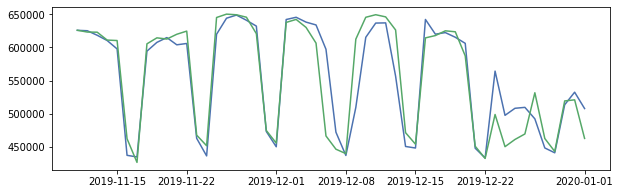

In [ ]:
# train with exogeneous variables

import numpy as np
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train, y_train_n)
y_pred_rf = rf.predict(X_test)
y_pred_rf_rescaled = rescale(y_pred_rf, y_test_n.index) #pd.Series(y_pred_rf_rescaled[:,0], index = y_test_n.index)

plt.figure(figsize = (10,3))
plt.plot(y_pred_rf_rescaled)
plt.plot(test[num_lags:])

err = 'Mean absolute percentage error: %.2f'% MAPE(test[num_lags:], y_pred_rf_rescaled) + \
'\nRoot mean squared error: %.2f'% np.sqrt(MSE(test[num_lags:], y_pred_rf_rescaled))

print(err)

In [ ]:
results_onestep_moving.append(['Random forest', y_pred_rf_rescaled,
                               MAPE(test[num_lags:], y_pred_rf_rescaled),
                               np.sqrt(MSE(test[num_lags:], y_pred_rf_rescaled))])

## LSTM training

In [ ]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense


In [ ]:
# reshape data to 3D-shape expected by LSTMs: [samples, timesteps, features]
import numpy as np

X_train_scaled_3d = np.array(X_train).reshape((X_train.shape[0], num_lags, n_features))
print(X_train_scaled_3d.shape)

X_test_scaled_3d = np.array(X_test).reshape((X_test.shape[0], num_lags, n_features))
print(X_test_scaled_3d.shape)

X_train_scaled_3d_uni = np.array(X_train_uni).reshape((X_train_uni.shape[0], num_lags, n_features_uni))
X_test_scaled_3d_uni = np.array(X_test_uni).reshape((X_test_uni.shape[0], num_lags, n_features_uni))

(1025, 10, 4)
(52, 10, 4)


Epoch 1/100
15/15 - 3s - loss: 0.4059 - 3s/epoch - 228ms/step
Epoch 2/100
15/15 - 0s - loss: 0.1952 - 180ms/epoch - 12ms/step
Epoch 3/100
15/15 - 0s - loss: 0.1851 - 174ms/epoch - 12ms/step
Epoch 4/100
15/15 - 0s - loss: 0.1800 - 174ms/epoch - 12ms/step
Epoch 5/100
15/15 - 0s - loss: 0.1779 - 174ms/epoch - 12ms/step
Epoch 6/100
15/15 - 0s - loss: 0.1778 - 194ms/epoch - 13ms/step
Epoch 7/100
15/15 - 0s - loss: 0.1783 - 187ms/epoch - 12ms/step
Epoch 8/100
15/15 - 0s - loss: 0.1781 - 173ms/epoch - 12ms/step
Epoch 9/100
15/15 - 0s - loss: 0.1776 - 203ms/epoch - 14ms/step
Epoch 10/100
15/15 - 0s - loss: 0.1770 - 181ms/epoch - 12ms/step
Epoch 11/100
15/15 - 0s - loss: 0.1769 - 186ms/epoch - 12ms/step
Epoch 12/100
15/15 - 0s - loss: 0.1763 - 178ms/epoch - 12ms/step
Epoch 13/100
15/15 - 0s - loss: 0.1760 - 175ms/epoch - 12ms/step
Epoch 14/100
15/15 - 0s - loss: 0.1753 - 179ms/epoch - 12ms/step
Epoch 15/100
15/15 - 0s - loss: 0.1742 - 174ms/epoch - 12ms/step
Epoch 16/100
15/15 - 0s - loss: 0.17

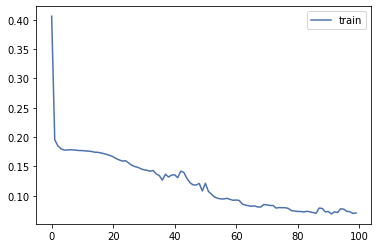

Epoch 1/100
15/15 - 3s - loss: 0.3458 - 3s/epoch - 219ms/step
Epoch 2/100
15/15 - 0s - loss: 0.2194 - 205ms/epoch - 14ms/step
Epoch 3/100
15/15 - 0s - loss: 0.1946 - 170ms/epoch - 11ms/step
Epoch 4/100
15/15 - 0s - loss: 0.1727 - 172ms/epoch - 11ms/step
Epoch 5/100
15/15 - 0s - loss: 0.1662 - 176ms/epoch - 12ms/step
Epoch 6/100
15/15 - 0s - loss: 0.1594 - 170ms/epoch - 11ms/step
Epoch 7/100
15/15 - 0s - loss: 0.1525 - 174ms/epoch - 12ms/step
Epoch 8/100
15/15 - 0s - loss: 0.1475 - 194ms/epoch - 13ms/step
Epoch 9/100
15/15 - 0s - loss: 0.1413 - 173ms/epoch - 12ms/step
Epoch 10/100
15/15 - 0s - loss: 0.1350 - 173ms/epoch - 12ms/step
Epoch 11/100
15/15 - 0s - loss: 0.1260 - 179ms/epoch - 12ms/step
Epoch 12/100
15/15 - 0s - loss: 0.1183 - 171ms/epoch - 11ms/step
Epoch 13/100
15/15 - 0s - loss: 0.1138 - 195ms/epoch - 13ms/step
Epoch 14/100
15/15 - 0s - loss: 0.1118 - 176ms/epoch - 12ms/step
Epoch 15/100
15/15 - 0s - loss: 0.1089 - 173ms/epoch - 12ms/step
Epoch 16/100
15/15 - 0s - loss: 0.10

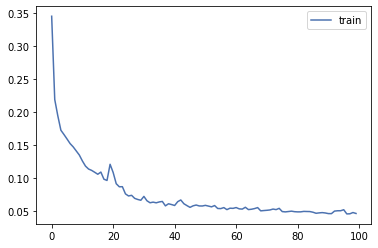

In [ ]:
def get_lstm_model(input):

    # network architecture
    model_lstm = Sequential()
    model_lstm.add(LSTM(50, return_sequences=True, 
                        input_shape=(input[1], input[2])))
    model_lstm.add(LSTM(50, activation='relu'))
    model_lstm.add(Dense(num_predict_steps))
    model_lstm.compile(loss='mae', optimizer='adam')

    return model_lstm

# model with no exogeneous variables
model_lstm = get_lstm_model(X_train_scaled_3d_uni.shape)

# model with exogeneous variables
model_lstm_exo = get_lstm_model(X_train_scaled_3d.shape)

# training without exogeneous variables
history_uni = model_lstm.fit(X_train_scaled_3d_uni, y_train_n, 
                    epochs=100, 
                    batch_size=72, 
                    #validation_data=(X_test_scaled_3d, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history_uni.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# training with exogeneous variables
history = model_lstm_exo.fit(X_train_scaled_3d, y_train_n, 
                    epochs=100, 
                    batch_size=72, 
                    #validation_data=(X_test_scaled_3d, y_test_n), 
                    verbose=2, 
                    shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## LSTM forecasts

In [ ]:
def get_lstm_predictions(model_lstm, test_data):
    '''
    Return model predictions on test_data, rescaled to original scale.
    '''
    preds_lstm = model_lstm.predict(test_data).flatten()
    # rescale predictions to original scale
    preds_lstm_rescaled = rescale(preds_lstm, index = y_test_n.index)

    return preds_lstm_rescaled

# rescale y_test to original scale (for latter plotting)
y_test_rescaled = rescale(np.array(y_test_n), index = y_test_n.index)

# compute onestep moving origin predictions, with exogeneous variables
preds_lstm_rescaled = get_lstm_predictions(model_lstm_exo, X_test_scaled_3d)
results_onestep_moving.append(['LSTM exo', preds_lstm_rescaled,
                              MAPE(y_test_rescaled, preds_lstm_rescaled),
                              np.sqrt(MSE(y_test_rescaled, preds_lstm_rescaled))])

# compute onestep moving origin predictions, no exogeneous variables
preds_lstm_rescaled = get_lstm_predictions(model_lstm, X_test_scaled_3d_uni)
results_onestep_moving.append(['LSTM', preds_lstm_rescaled,
                              MAPE(y_test_rescaled, preds_lstm_rescaled),
                              np.sqrt(MSE(y_test_rescaled, preds_lstm_rescaled))])



In [ ]:
# compute one-step fixed origin predictions, no exogeneous variables
import datetime

def onestep_fixed(model):
    '''
    Create one-step fixed predictions for lstm model. 
    Only implemented for univariate case (i.e. no exgoenegous variables).
    '''
    preds = []
    X0 = X_test_uni.iloc[0]
    date = X_test_uni.index[0]

    dates = []
    
    X0_3d = np.array(X0).reshape((1, num_lags, n_features_uni))
    X0_3d_update = X0_3d

    for i in range(X_test.shape[0]):
        preds_lstm_one = model.predict(X0_3d_update).flatten()

        # update with new onestep forecast
        X0_3d_update = np.append(X0_3d_update[0][1:], preds_lstm_one)
        X0_3d_update = np.array(X0_3d_update).reshape((1, num_lags, n_features_uni))
        preds.append(preds_lstm_one[0])
        date += datetime.timedelta(days=1)
        dates.append(date)

    return pd.Series(preds, index = dates)

preds_onestep_fixed = onestep_fixed(model_lstm)
preds_onestep_fixed = rescale(preds_onestep_fixed.values, preds_onestep_fixed.index)


In [ ]:
results_onestep_fixed.append(['LSTM', preds_onestep_fixed, 
                              MAPE(y_test_rescaled, preds_onestep_fixed),
                              MSE(y_test_rescaled, preds_onestep_fixed)])

Mean absolute percentage error: 0.06
Root mean squared error: 47370.82


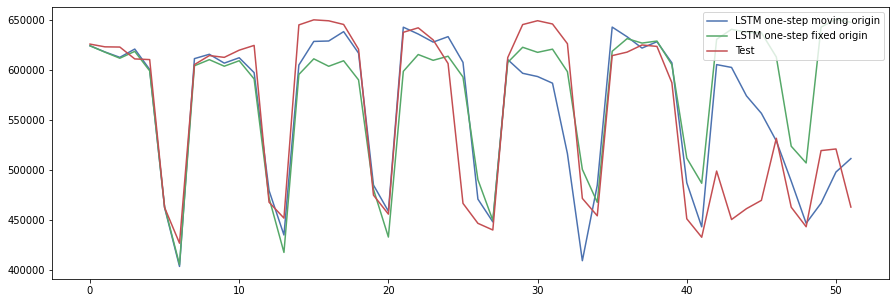

In [ ]:
plt.figure(figsize = (15,5))
plt.plot(np.array(preds_lstm_rescaled.values), label = "LSTM one-step moving origin")
plt.plot(np.array(preds_onestep_fixed.values), label = "LSTM one-step fixed origin")
plt.plot(np.array(y_test_rescaled), label = "Test")
plt.legend(loc = 'upper right')

err = 'Mean absolute percentage error: %.2f'% MAPE(test[num_lags:], preds_lstm_rescaled) + \
'\nRoot mean squared error: %.2f'% np.sqrt(MSE(test[num_lags:], preds_lstm_rescaled))

print(err)

# Final comparison

## One-step moving origin scenario

One-step moving forecasts


,MAPE
Model Name,
SARIMAX,0.045832
Random forest,0.037171
LSTM exo,0.050384
LSTM,0.058229


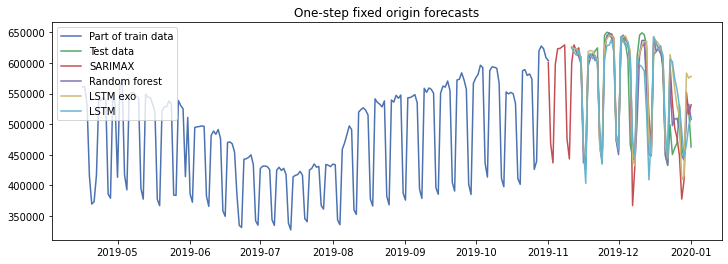

In [ ]:
# plots
print("One-step moving forecasts")
names, MAPEs = [], []

plt.figure(figsize = (12, 4))
plt.title("One-step fixed origin forecasts")
plt.plot(train[-200:], label = "Part of train data")
plt.plot(y_test_rescaled, label = "Test data")

for item in results_onestep_moving:
    names.append(item[0])
    MAPEs.append(item[2])
    plt.plot(item[1], label = item[0])

plt.legend(loc = "upper left")

comparison_moving = pd.DataFrame({'Model Name': names, 'MAPE': MAPEs})
comparison_moving = comparison_moving.set_index('Model Name')
comparison_moving

In [15]:
#!pip install dataframe_image
#df_styled = comparison_moving.style.background_gradient()
#import dataframe_image as dfi
#dfi.export(df_styled, 'electricity_comparison_moving.png', table_conversion = 'matplotlib')

## One-step fixed origin scenario

One-step fixed origin forecasts


,MAPE
Model Name,
SARIMAX,0.113873
LSTM,0.087600


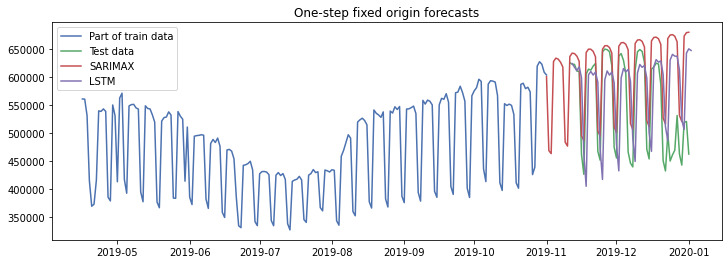

In [ ]:
print("One-step fixed origin forecasts")

names, MAPEs = [], []

plt.figure(figsize = (12, 4))
plt.title("One-step fixed origin forecasts")
plt.plot(train[-200:], label = "Part of train data")
plt.plot(y_test_rescaled, label = "Test data")

for item in results_onestep_fixed:
    names.append(item[0])
    MAPEs.append(item[2])
    plt.plot(item[1], label = item[0])

plt.legend(loc = "upper left")

comparison_fixed = pd.DataFrame({'Model Name': names, 'MAPE': MAPEs})
comparison_fixed = comparison_fixed.set_index('Model Name')
comparison_fixed